In this file I conduct the analysis of the biomarkers.
First, I look into the features selected by the DIABLO model.
Then, I perform the statistical testing to determine biomarker in a univariate analysis.

In [1]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import warnings
from methods.helper import *
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [2]:
# Palettes for consistent plotting

TWO_CLASS_PALETTE = {
    "Stable": "deepskyblue",
    "Decliner": "tomato"
}

THREE_CLASS_PALETTE = {
    "Stable": "deepskyblue",
    "Slow Decliner": "lightsalmon",
    "Fast Decliner": "tomato"
}

In [3]:
def map_class_labels(y_):
    """
    Map the class labels to the desired format
    :param y_: target variable
    :return: mapped target variable
    """
    if len(y_.unique()) == 2:
        mapping = {0: "Stable", 1: "Decliner"}
    else:
        mapping = {0: "Stable", 1: "Slow Decliner", 2: "Fast Decliner"}
    if 'Stable' not in y_.values:
        return y_.map(mapping)
    return y_

In [4]:
# Reading the data
lipidomics, metabolomics, proteomics = load_data()

# Get the features
lipidomics_features = lipidomics.drop(["RID", "TwoClass", "ThreeClass"], axis=1)
metabolomics_features = metabolomics.drop(["RID", "TwoClass", "ThreeClass"], axis=1)
proteomics_features = proteomics.drop(["RID", "TwoClass", "ThreeClass"], axis=1)

# Change the class labels
lipidomics["TwoClass"] = map_class_labels(lipidomics["TwoClass"])
lipidomics["ThreeClass"] = map_class_labels(lipidomics["ThreeClass"])
metabolomics["TwoClass"] = map_class_labels(metabolomics["TwoClass"])
metabolomics["ThreeClass"] = map_class_labels(metabolomics["ThreeClass"])
proteomics["TwoClass"] = map_class_labels(proteomics["TwoClass"])
proteomics["ThreeClass"] = map_class_labels(proteomics["ThreeClass"])

# Get the distribution of the target variable
print(proteomics["TwoClass"].value_counts())
print(proteomics["ThreeClass"].value_counts())

Stable      68
Decliner    28
Name: TwoClass, dtype: int64
Stable           55
Slow Decliner    22
Fast Decliner    19
Name: ThreeClass, dtype: int64


# 1. Investigation of the Features Selected from DIABLO

In [5]:
# Path to results
PATH = "C:\\Users\\mjgoj\\PycharmProjects\\ThesisFinal\\results\\"

In [6]:
# Read the DIABLO features
DIABLO_df = pd.read_csv(PATH + "\\diablo_features.csv")
DIABLO_df["Abs_Coefficient"] = np.abs(DIABLO_df["Coefficient"])

print(DIABLO_df["Component"].value_counts())
print(DIABLO_df["Block"].value_counts())

1    426
3    295
4    254
2    159
Name: Component, dtype: int64
Proteomics      428
Lipidomics      362
Metabolomics    344
Name: Block, dtype: int64


### Analysis of the Variables Selected by DIABLO
First, I will plot the distribution of the features selected by DIABLO in each component for each block.

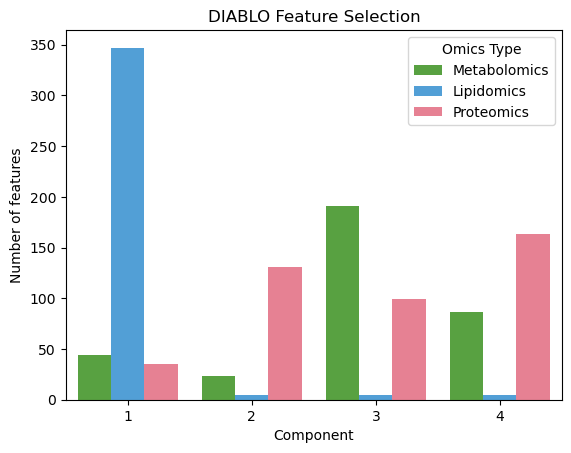

In [7]:
plot = sns.countplot(
    data=DIABLO_df, x="Component", hue="Block", palette=OMICS_PALETTE)
plot.set_title("DIABLO Feature Selection")
plot.set_xlabel("Component")
plot.set_ylabel("Number of features")
plot.legend(title="Omics Type")

### DIABLO Feature Importance
Now, I will plot the feature importance of the selected features.

Number of features:  254


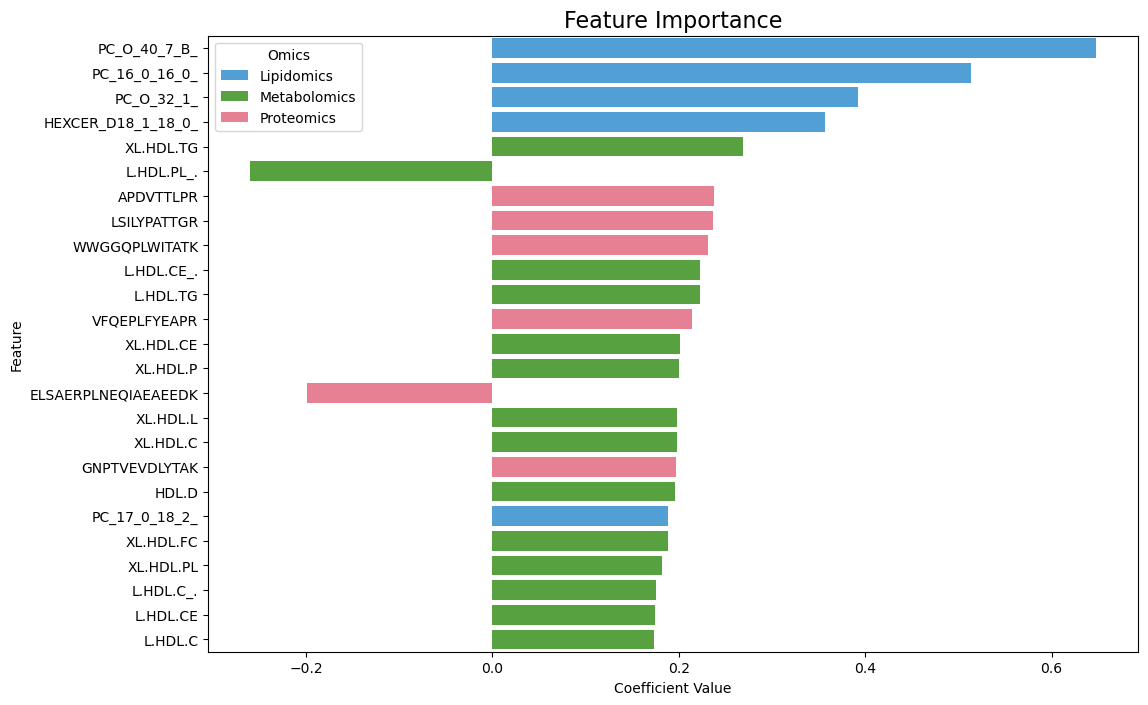

In [8]:
component = 4 # Specify the component to plot
# Filter the data based on the component
filtered_DIABLO_df = DIABLO_df[DIABLO_df["Component"] == component]

num_features = filtered_DIABLO_df.shape[0]
print("Number of features: ", num_features)
plot_feature_importance(
    filtered_DIABLO_df["Coefficient"],
    filtered_DIABLO_df["Feature"],
    n=num_features // 10
)

In [9]:
# Add the name of the feature
for i in range(DIABLO_df.shape[0]):
    # protein
    if DIABLO_df.at[i, "Block"] == "Proteomics":
        DIABLO_df.at[i, "Name"] = get_protein_name(DIABLO_df.at[i, "Feature"])
        DIABLO_df.at[i, "Full Name"] = f"{DIABLO_df.at[i, 'Feature']} ({DIABLO_df.at[i, 'Name']})"
    # metabolite
    elif DIABLO_df.at[i, "Block"] == "Metabolomics":
        DIABLO_df.at[i, "Name"] = get_metabolite_name(DIABLO_df.at[i, "Feature"])
        DIABLO_df.at[i, "Full Name"] = f"{DIABLO_df.at[i, 'Feature']} ({DIABLO_df.at[i, 'Name']})"
    # lipid
    else:
        DIABLO_df.at[i, "Name"] = map_lipid_name(DIABLO_df.at[i, "Feature"])
        DIABLO_df.at[i, "Full Name"] = f"{DIABLO_df.at[i, 'Feature']})"

In [10]:
print(DIABLO_df.head(2))

   Feature  Coefficient         Block  Component  Abs_Coefficient  \
0  PUFA.FA     0.230084  Metabolomics          1         0.230084   
1  FAW6.FA     0.217473  Metabolomics          1         0.217473   

                                                Name  \
0  Ratio of polyunsaturated fatty acids to total ...   
1                                            Unknown   

                                           Full Name  
0  PUFA.FA (Ratio of polyunsaturated fatty acids ...  
1                                  FAW6.FA (Unknown)  


In [11]:
# Get the features that appear across many components
min_occurrences = 3
for feature in DIABLO_df["Full Name"].unique():
    occurrences = DIABLO_df[DIABLO_df["Full Name"] == feature]["Component"].unique()
    if len(occurrences) >= min_occurrences:
        print(feature, '-> ',occurrences)

S.HDL.TG (Triglycerides in small HDL (mmol/l) (s5)) ->  [1 3 4]
S.VLDL.PL (Phospholipids in small VLDL (mmol/l) (s5)) ->  [1 3 4]
VQLVVGDGR (PIMT_HUMAN) ->  [1 2 4]
VLTHSELAPLR (SPRL1_HUMAN) ->  [2 3 4]
LGAEVYHTLK (ENOG_HUMAN) ->  [2 3 4]
ATGEGLIR (CSTN3_HUMAN) ->  [2 3 4]
SGETVINTANYHDTSPYR (LPHN1_HUMAN) ->  [2 3 4]
LPHTLR (KLK11_HUMAN) ->  [2 3 4]
EQDAPVAGLQPVER (LTBP2_HUMAN) ->  [2 3 4]
LSINTHPSQKPLSITVR (CO3_HUMAN) ->  [2 3 4]
AATVGSLAGQPLQER (APOE_HUMAN) ->  [2 3 4]
LSILYPATTGR (PRDX6_HUMAN) ->  [2 3 4]
VTGVVLFR (SODE_HUMAN) ->  [2 3 4]
SFTLASSETGVGAPISGPGIPGR (CH3L1_HUMAN) ->  [2 3 4]
GNPVPQQYLWEK (CADM3_HUMAN) ->  [2 3 4]
ILGQQVPYATK (CH3L1_HUMAN) ->  [2 3 4]
LGERPPALLGSQGLR (NRX2A_HUMAN) ->  [2 3 4]
GVHYISVSATR (DAG1_HUMAN) ->  [2 3 4]
WWGGQPLWITATK (ENPP2_HUMAN) ->  [2 3 4]
VTIDSSYDIAK (CH3L1_HUMAN) ->  [2 3 4]


### Plotting the coefficients of the features

Next cell can be modified to plot specific components, blocks and features with positive or negative coefficients.

In [12]:
Component = 'all' # Decide which component to plot
Block = "Proteomics" # Decide which block to plot

# Filter the data based on sign of the coefficient
filter = {"Positive": True,"Negative": True}
Target = "ThreeClass" # Target variable (ThreeClass or TwoClass)

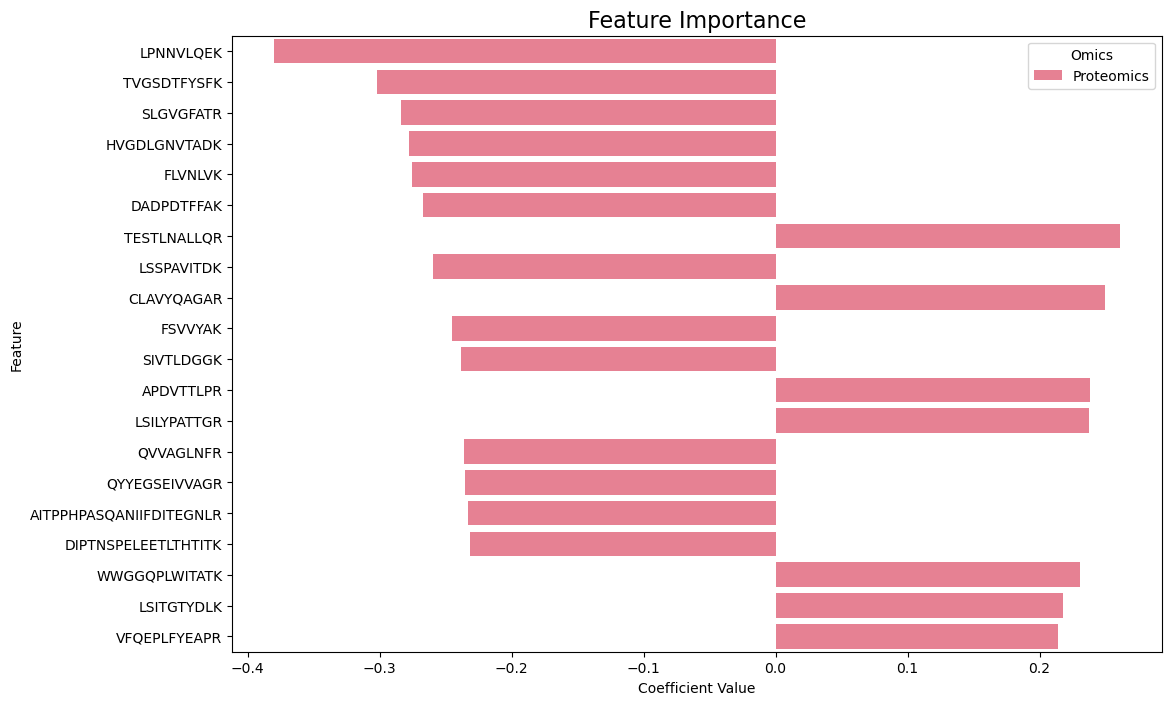

In [13]:
# Filter the data based on the component and the sign of the coefficient
if Component == 'all':
    if Block == 'all':
        data = (DIABLO_df.sort_values(by="Abs_Coefficient", ascending=False))
    else:  
        data = (DIABLO_df.where(DIABLO_df["Block"] == Block).dropna().
                sort_values(by="Abs_Coefficient", ascending=False))
else:
    if Block == 'all':
        data = (DIABLO_df.where(DIABLO_df["Component"] == Component).dropna().
                sort_values(by="Abs_Coefficient", ascending=False))
    else:
        data = (DIABLO_df.where(DIABLO_df["Block"] == Block).
                where(DIABLO_df["Component"] == Component).dropna().
                sort_values(by="Abs_Coefficient", ascending=False))
    
if not filter["Positive"]:
    data = data.where(data["Coefficient"] < 0).dropna()
if not filter["Negative"]:
    data = data.where(data["Coefficient"] > 0).dropna()
    
plot_feature_importance(data["Coefficient"], data["Feature"], n=20)

Now, based on the previous filtering I will plot the distribution of the selected features (only proteins).

In [14]:
# Group the data by the target variable

# select the features and the target variable
X = proteomics[data["Feature"]]
# Change the column names to the protein names
X.columns = [
    protein_name for feature, protein_name in zip(X.columns, data["Full Name"])]
y = proteomics[['ThreeClass']]
merged = pd.concat([X, y], axis=1)

# Remove duplicate columns
merged = merged.loc[:, ~merged.columns.duplicated()]
print(merged.head(2))

   LPNNVLQEK (AFAM_HUMAN)  TVGSDTFYSFK (KNG1_HUMAN)  SLGVGFATR (FABPH_HUMAN)  \
0               22.765464                 17.073860                23.345360   
1               23.215033                 17.420924                25.633415   

   HVGDLGNVTADK (SODC_HUMAN)  FLVNLVK (AFAM_HUMAN)  DADPDTFFAK (AFAM_HUMAN)  \
0                  24.841249             29.364073                24.178851   
1                  24.183709             29.119756                24.842548   

   TESTLNALLQR (NPTX2_HUMAN)  LSSPAVITDK (PLMN_HUMAN)  \
0                  13.409205                16.910792   
1                  15.482617                17.343241   

   CLAVYQAGAR (APOE_HUMAN)  FSVVYAK (FETUA_HUMAN)  ...  \
0                 3.594493              34.352975  ...   
1                 7.681348              35.447761  ...   

   VTASDPLDTLGSEGALSPGGVASLLR (CO4A_HUMAN)  DVVASLVSTR (NEO1_HUMAN)  \
0                                27.553286                30.302439   
1                               

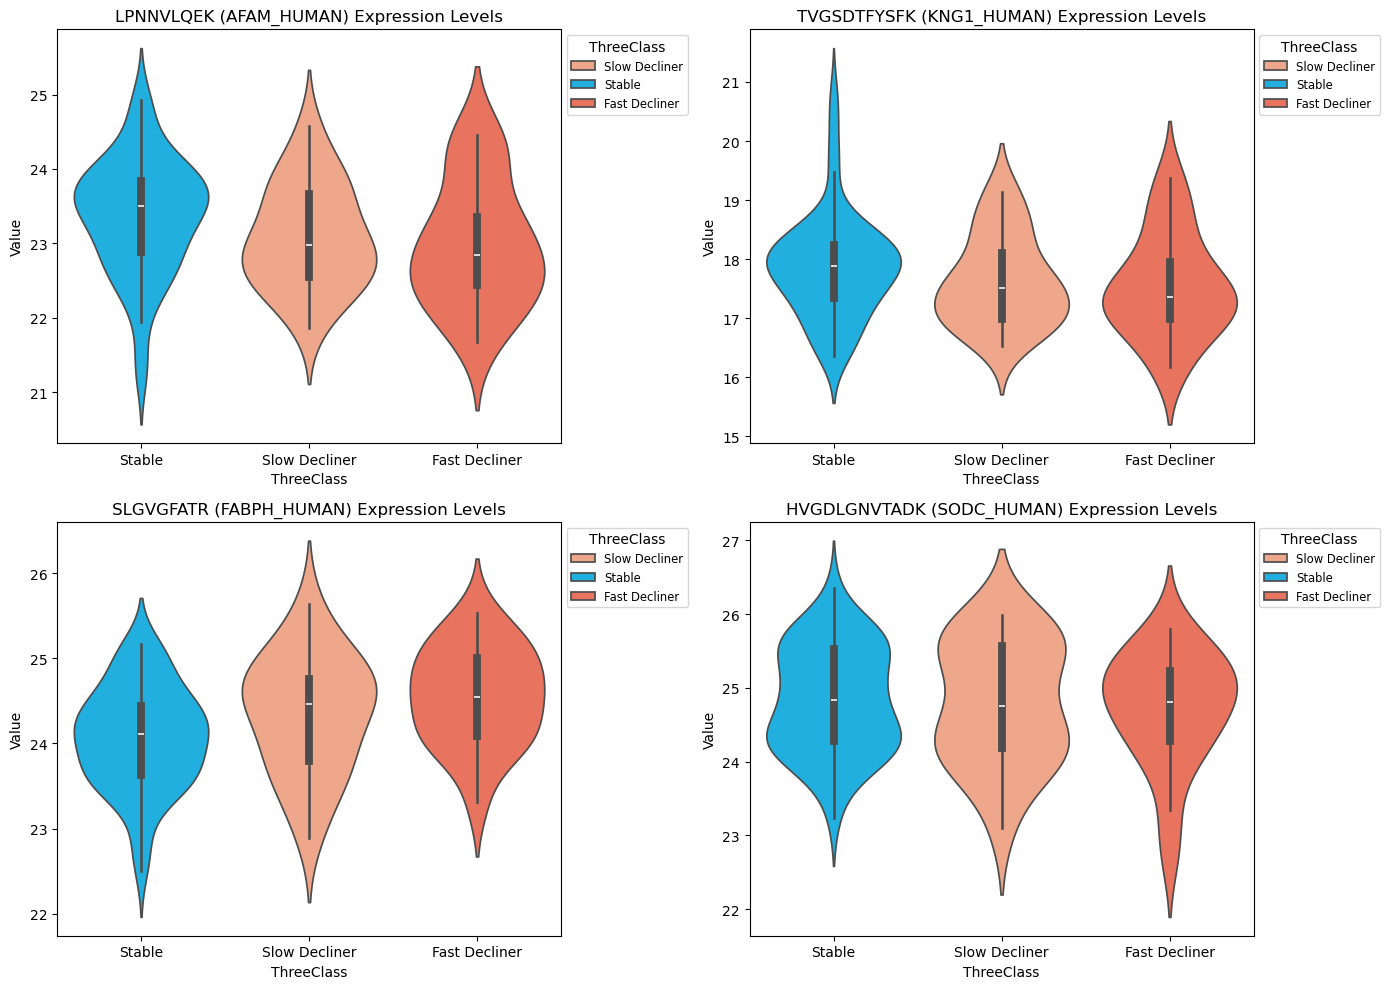

In [15]:
# Melting the dataframe to long format for seaborn boxplot
long_df = pd.melt(merged, id_vars=Target, var_name="Full Name", value_name='Value')

# Choose the appropriate palette
palette = THREE_CLASS_PALETTE if Target == "ThreeClass" else TWO_CLASS_PALETTE

# Choose the order of the classes
order = ["Stable", "Slow Decliner", "Fast Decliner"
] if Target == "ThreeClass" else ["Stable", "Decliner"]

# Specify the proteins to plot in array, if None random will be selected
specific_proteins = None
if specific_proteins is not None:
    long_df = long_df[long_df["Full Name"].isin(specific_proteins)]

# Decide on the number of subplots
num_subplots = len(long_df["Full Name"].unique())
num_per_row, max_rows = 2 if num_subplots % 2 == 0 else 3, 2
if num_subplots < 2:
    num_per_row, max_rows = 1, 1
nrow, ncol = min((num_subplots // num_per_row), max_rows), num_per_row

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5), squeeze=False)
for i, protein_name in enumerate(long_df["Full Name"].unique()):
    if i >= max_rows * num_per_row:
        break
    ax_idx = ax[i // ncol, i % ncol]
    plot = sns.violinplot(
        data=long_df[long_df["Full Name"] == protein_name],
        x=Target, y="Value", hue=Target, palette=palette, ax=ax_idx,
        legend='full', order=order
    )
    plot.set_title(protein_name + " Expression Levels")
    plot.set_ylabel("Value")
    plot.legend(
        title=Target, loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plot.set_xticklabels(order)

plt.tight_layout()
plt.show()

# 2. Significance Testing for the Univariate Analysis
Includes statistical tests and Cohen's D effect size calculation.

In [16]:
def commit_statistical_test(data_, alpha=0.05, testing_correction=True):
    """
    Perform the statistical test to determine the significant features
    If the data is not normally distributed, Mann-Whitney U test is performed.
    Otherwise, T test is performed.
    Normality is tested using Shapiro-Wilk test.
    :param data_: data to test
    :param alpha: significance level
    :param testing_correction: whether to apply the testing correction
    :return: dataframe with the p-values
    """
    # Drop the columns that are not needed
    if "RID" in data_.columns:
        data_ = data_.drop("RID", axis=1)
    if "ThreeClass" in data_.columns:
        data_ = data_.drop("ThreeClass", axis=1)
    # Drop the target variable
    features = data_.columns.drop(["TwoClass"])
    
    p_values = []
    for feature in features:
        stable_ = data_[data_["TwoClass"] == "Stable"][feature]
        decliner_ = data_[data_["TwoClass"] == "Decliner"][feature]
        
        # If the data is not normally distributed
        if stats.shapiro(stable_)[1] < 0.05 or stats.shapiro(decliner_)[1] < 0.05:
            # perform Mann-Whitney U test
            # null hypothesis that the distribution underlying sample x is the 
            # same as the distribution underlying sample y.
            statistic, pvalue = stats.mannwhitneyu(
                stable_, decliner_, alternative='two-sided'
            )
        # If the data is normally distributed
        else:
            # T test
           t_stat, pvalue = stats.ttest_ind(stable_, decliner_, equal_var=True)
        p_values.append(pvalue)
    
    # Account for multiple testing
    if testing_correction:
        p_values = multipletests(p_values, alpha=alpha, method='fdr_bh')[1]
    
    return pd.DataFrame({"Feature": features, "P-Value": p_values})

In [17]:
def plot_test_distribution(
        test_results, significance_cutoff=0.05, 
        title="Distribution of p-values", n_bins=35):
    """
    Plot the distribution of the p-values
    :param test_results: results of the statistical test
    :param significance_cutoff: significance cutoff
    :param title: title of the plot
    :param n_bins: number of bins
    :return: None
    """
        
    plt.figure(figsize=(6, 4))
    sns.histplot(test_results, bins=n_bins, color="deepskyblue")
    plt.axvline(
        x=significance_cutoff, color="firebrick", linestyle="--", 
        linewidth=1, label="alpha = " + str(significance_cutoff)
    )
    plt.xlabel("P-value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

# Testing Correction

**Benjamini-Hochberg Procedure**
Controls the False Discovery Rate (FDR), which is the expected proportion of false discoveries among the rejected hypotheses. It's less conservative than Bonferroni and is particularly useful for a large number of tests.

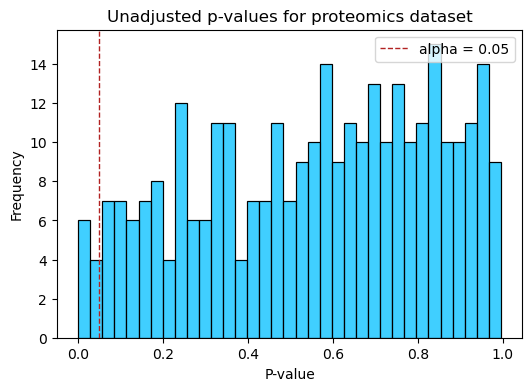

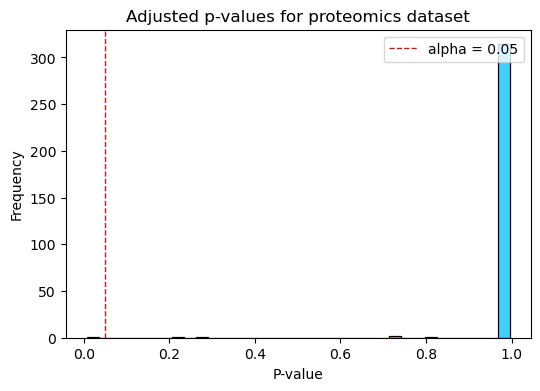

In [18]:
proteomics_test_unadjusted = commit_statistical_test(
    proteomics, testing_correction=False, alpha=0.05)
plot_test_distribution(
    proteomics_test_unadjusted["P-Value"], 
    title="Unadjusted p-values for proteomics dataset")

proteomics_test_adjusted = commit_statistical_test(
    proteomics, testing_correction=True, alpha=0.05)
plot_test_distribution(
    proteomics_test_adjusted["P-Value"], 
    title="Adjusted p-values for proteomics dataset")

# Cohen's D
Compares the difference between two means in terms of standard deviations. 
Interpretation:
- 0.5: Half the standard deviation.
- 1: Equal to the standard deviation.
- 2: Twice the standard deviation.

In [19]:
def get_cohens_d(group1, group2):
    """
    Calculate the Cohen's D effect size
    :param group1: negative group
    :param group2: positive group
    :return: effect size
    Formula source: https://en.wikipedia.org/wiki/Effect_size
    """
    mean1, mean2 = group1.mean(), group2.mean()
    variance1, variance2 = group1.var(), group2.var()
    n1, n2 = len(group1), len(group2)
    
    pooled_std = np.sqrt(((n1 - 1) * variance1 + (n2 - 1) * variance2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std


def get_effect_size(cohens_d):
    """
    Get the effect size based on the Cohen's D value
    :param cohens_d: Cohen's D value
    :return: effect size
    """
    if np.abs(cohens_d) >= 0.8:
        return "Large"
    elif np.abs(cohens_d) >= 0.5:
        return "Medium"
    elif np.abs(cohens_d) >= 0.2:
        return "Small"
    else:
        return "None"

In [20]:
def commit_Cohens_D(data_):
    # Drop the columns that are not needed
    if "RID" in data_.columns:
        data_ = data_.drop("RID", axis=1)
    if "ThreeClass" in data_.columns:
        data_ = data_.drop("ThreeClass", axis=1)
    # Drop the target variable
    features = data_.columns.drop(["TwoClass"])
    
    # Prepare the dataframe
    effect_sizes = pd.DataFrame(columns=["Feature", "Cohen's D", "Effect Size"])
    # scaler = StandardScaler()
    # data_[features] = scaler.fit_transform(data_[features])

    for feature in features:
        # Get the groups
        stable_ = data_[data_["TwoClass"] == "Stable"][feature]
        decliner_ = data_[data_["TwoClass"] == "Decliner"][feature]
        
        d = get_cohens_d(decliner_, stable_)
        effect_sizes = effect_sizes.append({
            "Feature": feature, "Cohen's D": d,
            "Abs Cohen's D": np.abs(d), "Effect Size": get_effect_size(d)
        }, ignore_index=True)
    return effect_sizes

In [21]:
def plot_Cohens_D(effect_sizes, omics_type, bins=35):
    """
    Plot the distribution of cohen's d values and effect sizes
    :param effect_sizes: dataframe with the effect sizes
    :param omics_type: type of omics data
    :param bins: number of bins
    """
    
    # Create figure and axis
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    
    # Calculate histogram
    counts, bin_edges = np.histogram(effect_sizes["Cohen's D"], bins=bins)
    
    # Define colors and patterns
    effect_dict = {
        "None": {"color": "#9b9b9b", "hatch": '//', 'edgecolor': 'white'},
        "Small": {"color": "#5ad45a", "hatch": None, 'edgecolor': 'white'},
        "Medium": {"color": "#00b7c7", "hatch": None, 'edgecolor': 'white'},
        "Large": {"color": "#4421af", "hatch": None, 'edgecolor': 'grey'}
    }
    
    # Plot bars with different colors and hatches
    for count, bin_left, bin_right in zip(counts, bin_edges, bin_edges[1:]):
        # Determine which effect size the bin belongs to
        # and get the most common effect size in this bin
        effect_size = effect_sizes.loc[
            (effect_sizes["Cohen's D"] >= bin_left) & (effect_sizes["Cohen's D"] < bin_right), 'Effect Size'].mode()  
        if not effect_size.empty:
            effect = effect_size.values[0]
        
        # Get color and hatch pattern
        color = effect_dict[effect]["color"]
        hatch = effect_dict[effect]["hatch"]
        
        # Create a rectangle with the given color and hatch
        rect = Rectangle(
            (bin_left, 0), bin_right - bin_left, count, 
            facecolor=color, hatch=hatch, edgecolor=effect_dict[effect]['edgecolor'])
        ax.add_patch(rect)
    
    # Set labels and title
    plt.xlabel("Effect Size")
    plt.ylabel("Frequency")
    title = "Distribution of Cohen's D values for " + omics_type
    plt.title(title, fontsize=14)
    
    # Manually set x-axis limits
    plt.xlim([bin_edges.min() - 0.1, bin_edges.max() + 0.1])
    plt.ylim([0, counts.max() * 1.1])  # a little extra space at the top
    plt.legend(
        handles=[
            Rectangle((0, 0), 1, 1, facecolor=effect_dict[effect]["color"], hatch=effect_dict[effect]["hatch"], edgecolor='white')
            for effect in effect_dict
        ],
        labels=effect_dict.keys(),
        title="Effect Size",
        loc="upper right"
    )
    # Show plot
    plt.show()

In [22]:
def get_biomarkers(X, p_cutoff=0.05, d_cutoff=0.2):
    """
    Biomarkers are defined as features that have a p-value less than p_cutoff 
    and an effect size greater than d_cutoff.
    :param X: data to test
    :param p_cutoff: significance threshold for the statistical test
    :param d_cutoff: effect size threshold
    :return: dataframe with the significant features
    """
    # Perform the statistical test
    statistical_df = commit_statistical_test(X, testing_correction=False)
    # Calculate the effect size
    cohensD_df = commit_Cohens_D(X)
    # Merge the dataframes
    final_df = cohensD_df.merge(statistical_df, on="Feature")
    # Filter the significant features
    return final_df[
        (final_df["P-Value"] < p_cutoff) & (final_df["Abs Cohen's D"] >= d_cutoff)]

In [23]:
def plot_statistical_significance(
        statistical_test, effect_sizes, log=True, label="Proteomics"):
    """
    Plot the statistical significance of the features across the effect sizes
    :param statistical_test: dataframe with the p-values
    :param effect_sizes: dataframe with the effect sizes
    :param log: whether to plot the log of the p-values
    :param label: label of the plot
    """
    
    # Define the colors for the effect sizes
    effect_dict = {
        "None": "#9b9b9b",
        "Small": "#5ad45a",
        "Medium": "#00b7c7",
        "Large": "#4421af"
     }
    
    # Merge the dataframes with the effect sizes and the p-values   
    significance = effect_sizes.merge(statistical_test, on="Feature")
    # Get the -log10 of the p-values
    significance['Log P-value'] = -np.log10(significance['P-Value'])
    if log:
        x, p_cutoff, x_step = "Log P-value", -np.log10(0.05), 0.2
    else:
        x, p_cutoff, x_step = "P-Value", 0.05, 0.05
        
    sns.scatterplot(
        data=significance, x=x, y="Abs Cohen's D", 
        hue="Effect Size", palette=effect_dict, s=100, alpha=1,
        hue_order=["None", "Small", "Medium", "Large"], legend="full"
    )
    # P value cutoffs
    plt.axvline(
        x=p_cutoff, color="#e60049", linestyle="--", 
        linewidth=0.5, label="alpha = 0.05")
    
    # I wanted to make the plots for different omics data consistent
    x_lim = (-0.2, 4.9)
    y_lim = (-0.05, 1.05)
    
    # Effect size cutoff
    effect_size = 'Small'
    cutoff_color = effect_dict[effect_size]
    plt.axhline(
        y=0.2, color=cutoff_color, linestyle="--", 
        linewidth=0.5, label="d = " + str(0.2))
    # Draw the rectangle to highlight the significant features
    if log:
        plt.xlabel("-log10(P-Value)", fontsize=12, weight='bold')
        plt.fill_betweenx(
            y=[0.2, y_lim[1]] , x1=-np.log10(0.05), x2=x_lim[1],
            color='gray', alpha=0.2)
    else:
        plt.xlabel("P-Value", fontsize=12, weight='bold')
        plt.fill_betweenx(
            y=[0.2, y_lim[1]] , x1=x_lim[0], x2=p_cutoff, 
            color='gray', alpha=0.2)

    # Set labels and title
    plt.ylabel("Cohen's D", fontsize=12, weight='bold')
    plt.ylim(y_lim)
    plt.xlim(x_lim)
    plt.xticks(np.arange(x_lim[0], x_lim[1], x_step), rotation=45, fontsize=8)
    plt.legend(
        title="Effect Size", loc="upper right", 
        bbox_to_anchor=(1.3, 1), fontsize='small')
    plt.title(label)
    plt.show()

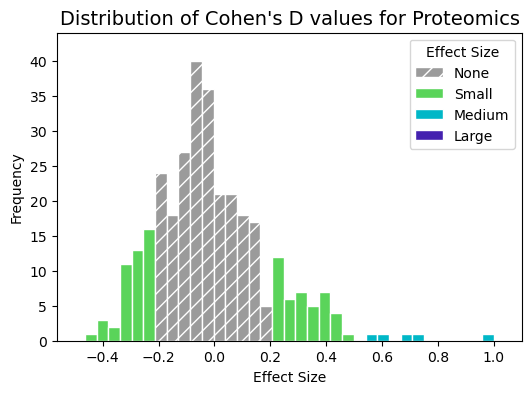

Large effect sizes: 
LGADMEDVR  ( APOE_HUMAN  )

Medium effect sizes: 
ILGQQVPYATK  ( CH3L1_HUMAN )
SFTLASSETGVGAPISGPGIPGR  ( CH3L1_HUMAN )
SIVTLDGGK  ( FABPH_HUMAN )
SLGVGFATR  ( FABPH_HUMAN )


In [24]:
# Calculate the effect size for the significant proteins
protein_effect_sizes = commit_Cohens_D(proteomics)
plot_Cohens_D(protein_effect_sizes, "Proteomics")

print("Large effect sizes: ")
for protein in protein_effect_sizes[protein_effect_sizes["Effect Size"] == "Large"]["Feature"]:
    print(protein, " (", get_protein_name(protein), ")")
    
print("\nMedium effect sizes: ")
for protein in protein_effect_sizes[protein_effect_sizes["Effect Size"] == "Medium"]["Feature"]:
    print(protein, " (", get_protein_name(protein), ")")

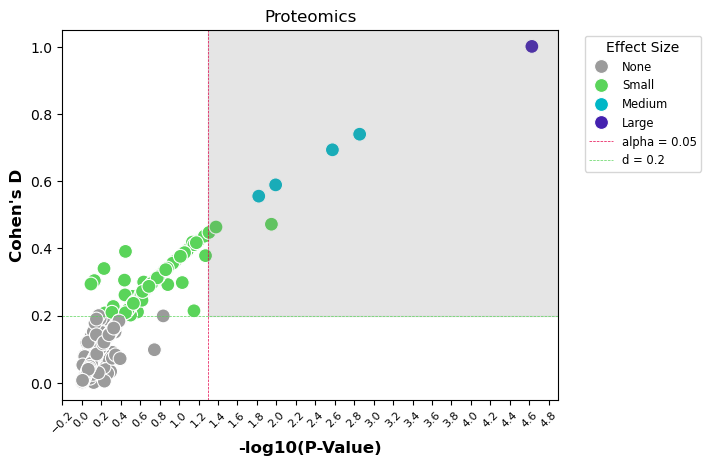

In [25]:
plot_statistical_significance(proteomics_test_unadjusted, protein_effect_sizes, label="Proteomics")

In [26]:
# Saving the significant proteins
significant_proteins = get_biomarkers(proteomics, p_cutoff=0.05, d_cutoff=0.2)
significant_proteins = significant_proteins.rename(
    columns={"Feature": "Peptide Sequence"})
# Add column with the protein name
significant_proteins["Protein Name"] = (significant_proteins["Peptide Sequence"].
                                        apply(get_protein_name))
# Delete columns that are not needed
significant_proteins = significant_proteins.drop(["Abs Cohen's D"], axis=1)
# Round the values
significant_proteins["Cohen's D"] = (significant_proteins["Cohen's D"].
                                     apply(lambda x: round(x, 4)))
significant_proteins["P-Value"] = (significant_proteins["P-Value"].
                                   apply(lambda x: round(x, 5)))
print(significant_proteins.head(2))
# Save to the path
significant_proteins.to_csv(PATH + "biomarkers_proteins.csv", index=False)

   Peptide Sequence  Cohen's D Effect Size  P-Value Protein Name
37        LGADMEDVR     1.0011       Large  0.00002  APOE_HUMAN 
45   ETPAATEAPSSTPK     0.4718       Small  0.01124  BASP1_HUMAN


# Metabolomics Analysis

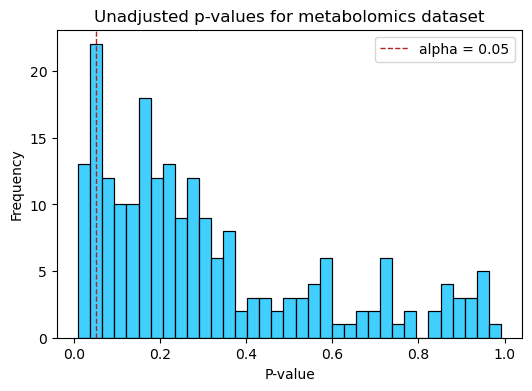

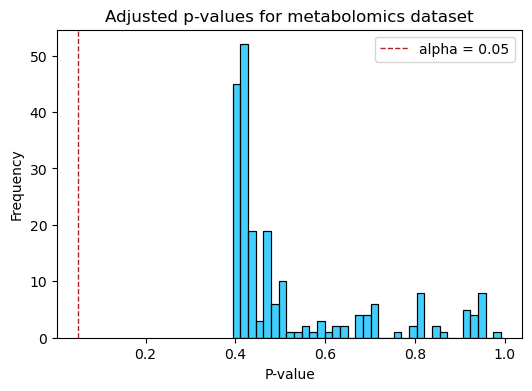

In [27]:
metabolomics_test_unadjusted = commit_statistical_test(
    metabolomics, testing_correction=False)
plot_test_distribution(
    metabolomics_test_unadjusted["P-Value"], 
    title="Unadjusted p-values for metabolomics dataset")

metabolomics_test_adjusted = commit_statistical_test(
    metabolomics, testing_correction=True)
plot_test_distribution(
    metabolomics_test_adjusted["P-Value"],
    title="Adjusted p-values for metabolomics dataset")

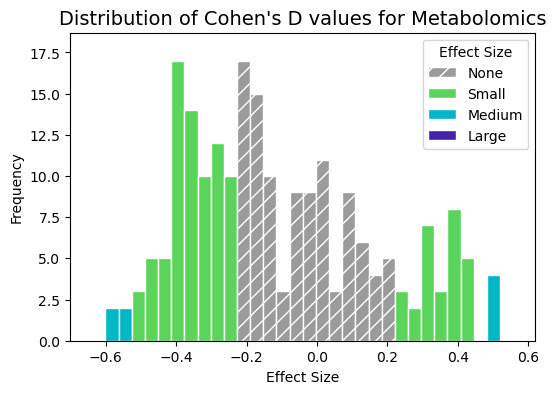

Large effect sizes: 

Medium effect sizes: 
M.VLDL.CE  ( Cholesteryl esters in medium VLDL (mmol/l) (s5) )
S.VLDL.C  ( Cholesterol in small VLDL (mmol/l) (s5) )
S.VLDL.CE  ( Cholesteryl esters in small VLDL (mmol/l) (s5) )
M.HDL.TG  ( Triglycerides in medium HDL (mmol/l) (s5) )
S.VLDL.PL_.  ( Phospholipids in small VLDL (mmol/l) (s5) )
VLDL.C  ( Cholesterol in large VLDL (mmol/l) (s5) )
ACE  ( Acetate (mmol/l) (s5) )
ACACE  ( Unknown )


In [28]:
metabolite_effect_sizes = commit_Cohens_D(metabolomics)
plot_Cohens_D(metabolite_effect_sizes, "Metabolomics", 30)

print("Large effect sizes: ")
for metabolite in metabolite_effect_sizes[
    metabolite_effect_sizes["Effect Size"] == "Large"]["Feature"]:
    print(metabolite, " (", get_metabolite_name(metabolite), ")")
    
print("\nMedium effect sizes: ")
for metabolite in metabolite_effect_sizes[
    metabolite_effect_sizes["Effect Size"] == "Medium"]["Feature"]:
    print(metabolite, " (", get_metabolite_name(metabolite), ")")

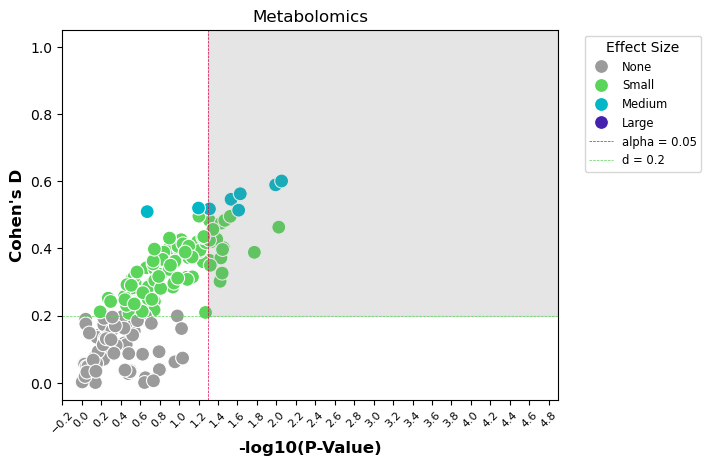

In [29]:
plot_statistical_significance(
    metabolomics_test_unadjusted, metabolite_effect_sizes, label="Metabolomics")

In [30]:
# Save the significant metabolites
significant_metabolites = get_biomarkers(
    metabolomics, p_cutoff=0.05, d_cutoff=0.2)
# Delete columns that are not needed
significant_metabolites = significant_metabolites.drop(["Abs Cohen's D"], axis=1)
# Round the values
significant_metabolites["Cohen's D"] = (significant_metabolites["Cohen's D"].
                                        apply(lambda x: round(x, 4)))
significant_metabolites["P-Value"] = (significant_metabolites["P-Value"].
                                      apply(lambda x: round(x, 5)))
# Rename the columns
significant_metabolites = significant_metabolites.rename(columns={"Feature": "ID"})
# Add the metabolite name
significant_metabolites["Metabolite Name"] = significant_metabolites["ID"].apply(get_metabolite_name)

print(significant_metabolites.shape)
# Save as a csv file
significant_metabolites.to_csv(PATH + "biomarkers_metabolites.csv", index=False)
# Print just the names
for i in significant_metabolites["Metabolite Name"].values:
    print(i)

(24, 5)
Cholesterol in medium VLDL (mmol/l) (s5)
Cholesteryl esters in medium VLDL (mmol/l) (s5)
Concentration of small VLDL particles (mmol/l) (s5)
Total lipids in small VLDL (mmol/l) (s5)
Phospholipids in small VLDL (mmol/l) (s5)
Cholesterol in small VLDL (mmol/l) (s5)
Cholesteryl esters in small VLDL (mmol/l) (s5)
Free cholesterol in small VLDL (mmol/l) (s5)
Concentration of very large HDL particles (mmol/l) (s5)
Phospholipids in very large HDL (mmol/l) (s5)
Cholesterol in large HDL (mmol/l) (s5)
Free cholesterol in large HDL (mmol/l) (s5)
Triglycerides in medium HDL (mmol/l) (s5)
Cholesteryl esters in IDL (mmol/l) (s5)
Phospholipids in large HDL (mmol/l) (s5)
Cholesterol in large HDL (mmol/l) (s5)
Cholesteryl esters in large HDL (mmol/l) (s5)
Free cholesterol in large HDL (mmol/l) (s5)
Triglycerides in medium HDL (mmol/l) (s5)
Unknown
Cholesterol in large VLDL (mmol/l) (s5)
Remnant cholesterol (non-HDL, non-LDL -cholesterol) (mmol/l) (s5)
Glycerol (mmol/l) (s5)
Acetate (mmol/l) (s5

# Lipidomics Analysis

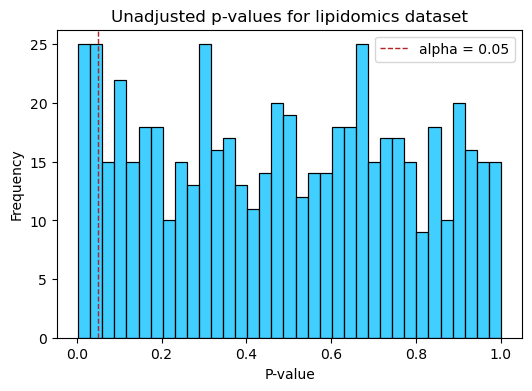

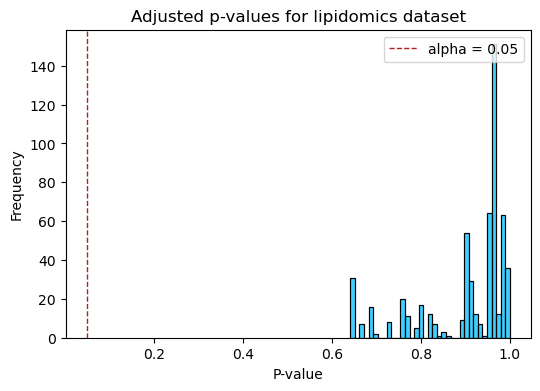

In [31]:
lipidomics_test_unadjusted = commit_statistical_test(
    lipidomics, testing_correction=False)
plot_test_distribution(
    lipidomics_test_unadjusted["P-Value"],
    title="Unadjusted p-values for lipidomics dataset")

lipidomics_test_adjusted = commit_statistical_test(
    lipidomics, testing_correction=True)
plot_test_distribution(
    lipidomics_test_adjusted["P-Value"],
    title="Adjusted p-values for lipidomics dataset")


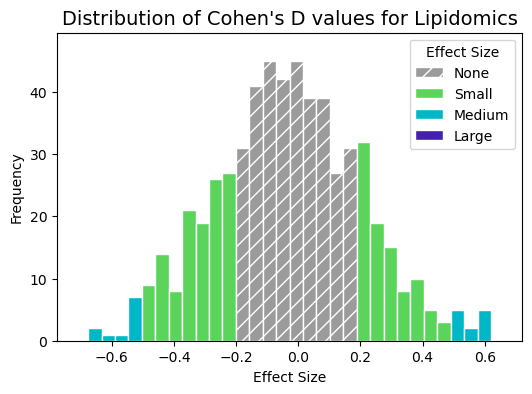

Large effect sizes: 

Medium effect sizes: 
CE_15_0_
CER_D19_1_18_0_
CER_D19_1_26_0_
DG_18_1_20_4_
DHCER_D18_0_22_0_
DHCER_D18_0_24_0_
GM3_D18_1_18_0_
GM3_D18_1_24_1_
HEXCER_D18_1_18_0_
HEXCER_D18_1_24_1_
LPC_O_24_2_
PC_18_0_18_1_
PC_18_0_20_3_
PC_36_0_
PC_38_2_
PC_40_7_A_
PI_20_0_20_4_
SM_D16_1_19_0_
SM_D18_0_22_0_
SM_D18_1_22_0__SM_D16_1_24_0_
SM_D19_1_24_1_


In [32]:
lipid_effect_sizes = commit_Cohens_D(lipidomics)
plot_Cohens_D(lipid_effect_sizes, "Lipidomics", 30)

print("Large effect sizes: ")
for lipid in lipid_effect_sizes[lipid_effect_sizes["Effect Size"] == "Large"]["Feature"]:
    print(lipid)
    
print("\nMedium effect sizes: ")
for lipid in lipid_effect_sizes[lipid_effect_sizes["Effect Size"] == "Medium"]["Feature"]:
    print(lipid)

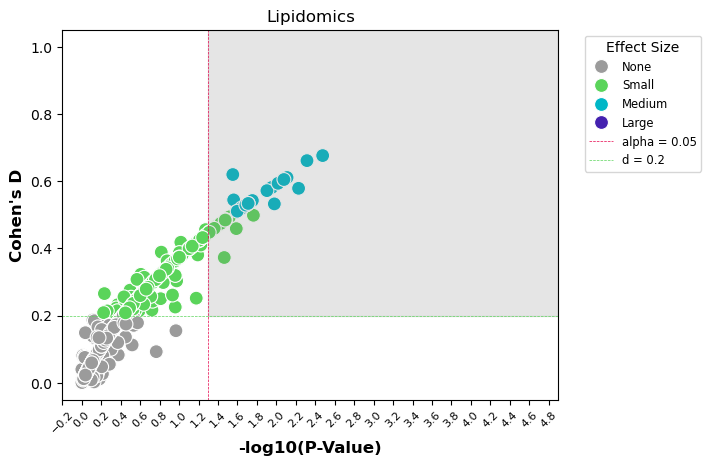

In [33]:
plot_statistical_significance(
    lipidomics_test_unadjusted, lipid_effect_sizes, label="Lipidomics")

In [34]:
# Save the significant lipids
significant_lipids = get_biomarkers(lipidomics, p_cutoff=0.05, d_cutoff=0.5)
# Delete columns that are not needed
significant_lipids = significant_lipids.drop(["Abs Cohen's D"], axis=1)
# Round the values
significant_lipids["Cohen's D"] = (significant_lipids["Cohen's D"].
                                   apply(lambda x: round(x, 4)))
significant_lipids["P-Value"] = (significant_lipids["P-Value"].
                                 apply(lambda x: round(x, 5)))
# Rename the columns
significant_lipids = significant_lipids.rename(columns={"Feature": "Lipid"})
print(significant_lipids.shape)
print(significant_lipids.head(21))

# Dave as a csv file
significant_lipids.to_csv(PATH + "biomarkers_lipids.csv", index=False)

(21, 4)
                             Lipid  Cohen's D Effect Size  P-Value
15                        CE_15_0_     0.5787      Medium  0.00591
72                 CER_D19_1_18_0_     0.6012      Medium  0.00875
77                 CER_D19_1_26_0_     0.6197      Medium  0.02805
106                  DG_18_1_20_4_    -0.5442      Medium  0.02748
112              DHCER_D18_0_22_0_    -0.6611      Medium  0.00484
113              DHCER_D18_0_24_0_    -0.5812      Medium  0.01117
117                GM3_D18_1_18_0_     0.5424      Medium  0.01765
121                GM3_D18_1_24_1_     0.5082      Medium  0.02592
135             HEXCER_D18_1_18_0_     0.5313      Medium  0.02003
139             HEXCER_D18_1_24_1_     0.5201      Medium  0.02273
205                    LPC_O_24_2_     0.6109      Medium  0.00777
267                  PC_18_0_18_1_    -0.5291      Medium  0.02053
269                  PC_18_0_20_3_    -0.6762      Medium  0.00334
294                       PC_36_0_    -0.5105      Med

Now I need to additionally format the lipid biomarkers in the way that they can be used in the LipidMaps tool.
[Link to the guidelines for the LipidMaps data preparation](https://lipidmaps.org/tool/biopan/doc/step1.html#how-to-prepare-your-data)


In [35]:
num_features = len(lipidomics_features.columns)
num_samples = lipidomics.shape[0]
print("Number of features: ", num_features)
print("Number of samples: ", num_samples)

# Prepare the names for the samples
sample_labels = lipidomics['TwoClass'].values.copy()
stable, decliner = 1, 1
for i in range(len(sample_labels)):
    if sample_labels[i] == 'Stable':
        sample_labels[i] = f"stable_{stable}"
        stable += 1
    else:
        sample_labels[i] = f"decliner_{decliner}"
        decliner += 1

# Read lipidomics data again in case it was overwritten
lipidomics, _, _ = load_data()
LipidMaps_df = lipidomics[lipidomics_features.columns].T
# Names of the columns should be the names of the classes
LipidMaps_df.columns = sample_labels
# Give the name to the index
LipidMaps_df.index.name = "sample"

Number of features:  579
Number of samples:  96


In [36]:
print(map_lipid_name("CE_15_0_"))
print(map_lipid_name("HEXCER_D18_1_24_1_"))
print(map_lipid_name("PC_P_17_0_20_4_A_"))

CE(15:0)
Glc-Cer(D18:1/24:1)
PC(P_17_0_20_4_A)


In [37]:
# Map the lipid names
LipidMaps_df.index = LipidMaps_df.index.map(map_lipid_name)
print(LipidMaps_df.head(2))
# Save as a csv file
LipidMaps_df.to_csv(PATH + "LipidMaps_data.csv")

           stable_1  stable_2  stable_3  stable_4  stable_5  stable_6  \
sample                                                                  
CAR(12:0)  2.501732  1.963655  2.453778  3.749041  3.767316  3.213848   
CAR(13:0)  0.894601  1.606381  1.910019  1.149975  1.613022  1.012976   

           stable_7  stable_8  stable_9  stable_10  ...  decliner_19  \
sample                                              ...                
CAR(12:0)  3.633431  2.828187  2.083744   1.592354  ...     2.831243   
CAR(13:0)  0.813089  1.438932  1.319051   1.308705  ...     2.672962   

           decliner_20  decliner_21  decliner_22  decliner_23  decliner_24  \
sample                                                                       
CAR(12:0)     4.103011     3.146303     4.526745     2.616078     3.705303   
CAR(13:0)     1.225398     2.286038     2.536563     1.817214     1.913313   

           decliner_25  decliner_26  decliner_27  decliner_28  
sample                                   